In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, learning_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


from google.colab import drive
drive.mount('/content/drive')

plt.style.use('fivethirtyeight')
%matplotlib inline

Mounted at /content/drive


In [ ]:
# define column names
names = ['x', 'y', 'class']

# loading data Dn
df = pd.read_csv('/content/drive/MyDrive/demo_data/3.concertriccir2.csv', header=None, names=names)

print(df.head())

          x         y  class
0  0.700335 -0.247068    0.0
1 -3.950019  2.740080    1.0
2  0.150222 -2.157638    1.0
3 -1.672050 -0.941519    1.0
4  2.560483 -1.846577    1.0


In [ ]:
# create design matrix X and target vector y
X = np.array(df.drop(['class'], axis=1))
y = np.array(df['class'])

In [ ]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
# test_size: defines the percentage of data X_test, y_test
# random_state: to control and fix a number of scatter points

print(f"X_train set: {X_train.shape}") # 80% of total dataset Dn
print(f"X_test: {X_test.shape}") # 20% of total dataset Dn

X_train set: (400, 2)
X_test: (100, 2)


This is what our train set and our test set look like:

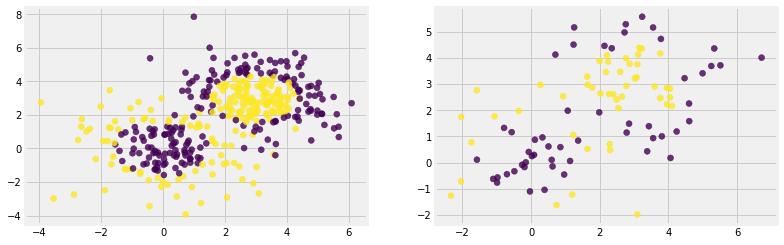

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, alpha=0.8)
plt.title='Train set'

plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.8)
plt.title='Test set'
plt.show()

In [ ]:
# let's create a model
# let's fix k to 1 and show the result
model = KNeighborsClassifier(n_neighbors=1)

model.fit(X_train, y_train)
print(f"Train score: {model.score(X_train, y_train) * 100.0}%")



Train score: 100.0%


We can see that if we evaluate our model on its same data, we get a score of 100%. But does that mean that our model will succeed 100% of its future predictions? No.<br>
To get an idea of the future performance of our model, we need to test it on the data from the test set, i.e. data that it has never seen.

In [ ]:
print(f"Test score: {model.score(X_test, y_test) * 100.0}%")

Test score: 93.0%


# Validation set to improve the model 
That's it, you now know how to properly train and evaluate a machine learning model! Now as a data scientist, your job is to improve this model and obtain a score of 94%, 95%, see 99%! For that you will have to adjust the hyper parameters of your model a bit like turning the knobs on a radio to adjust the signal.

In [ ]:
# For example if we change the number of neighbors to 5
model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train, y_train)
print(f"Test score: {model.score(X_test, y_test) * 100.0}%")

Test score: 92.0%


But be **careful** if we adjust our model by optimizing its performance on the test set, then we can no longer use the data from the test set to make the final evaluation of our model. remember the **unseen/future** data.<br>
For this reason we cut out a third section in our data set, which is none other than the validation set.<br>
Here! If you understood this through the course videos, great! You almost all understood! because there is one last thing to see, indeed what guarantees us that the way of splitting the dataset is the right one?<br>
So faced with this situation, there is a solution, **Cross validation** which consists in training and validating the model on several possible cutting of the dataset train (Dtrain). Note in passing that there are several ways to cut the train set with the technique They are all detailed on the sklearn site, and the one we just saw in the course is called `K-fold`.

In [ ]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=10, scoring='accuracy').mean() *100.0

88.00000000000001

So we could test this function in a for loop, recording each score we get in a list, then displaying these results we get the following graph:


The optimal number of neighbors is 3.


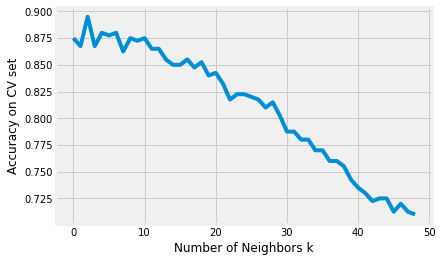

In [ ]:
# creating list of K for KNN
# neighbors = list(filter(lambda x: x%2,list(range(0, 50))))
neighbors = list(range(1, 50))

# empty list that will hold cv scores
val_score = []

# perform 10-fold cross validation
for k in neighbors:
  cv_scores = cross_val_score(KNeighborsClassifier(k), X_train, y_train, cv=10,scoring='accuracy')
  # append the mean of scores
  val_score.append(cv_scores.mean())


optimal_k = neighbors[val_score.index(max(val_score))]
print(f'\nThe optimal number of neighbors is {optimal_k}.')

plt.plot(val_score)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Accuracy on CV set')
plt.show()

Know what, this whole for loop, we don't have to write it down
because ther is a function in sklearn which allows to create this kind of graphics.


# validation_curve()

This function, we pass the model which is already predefined, as well as the data of the train set. Then we indicate in a character string '`n_neighbors`' the name of the hyper parameter that we want to adjust, then in the form of an iterator in our case `neighbors`, we will designate the different values that we want to test on hyper parameter.  
Finally we do not forget to specify the number of cuts we want to have in our cross validation. We get the same blue graph as the one above.  
But in addition to having the validation score, we can also have the score of the test train in red.

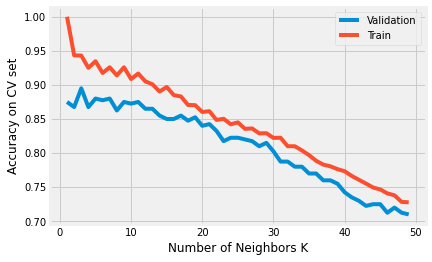

In [ ]:
model = KNeighborsClassifier()

train_score, val_score = validation_curve(model, X_train, y_train, 'n_neighbors', neighbors, cv=10)

plt.plot(neighbors, val_score.mean(axis=1), label='Validation')
plt.plot(neighbors, train_score.mean(axis=1), label='Train')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy on CV set')
plt.legend()
plt.show()

This graph is very useful for detecting the case of overfitting. that is, when the machine has lost all sense of generalization, because it has sought to improve itself too much on the data of the set train.  
But you now know that in the K-NN algorithm there are other hyper parameters than the number of neighbors K. We have for example the type of distances, Euclidean, Manhattan ... So by adjusting these other parameters we have may have better performance.  
So to test all these combinations it is best to use the `GreadSearchCV ` function.

# GreadSearchCV

`GridSearchCV()`, allows us to find the model with the best hyper parameters by comparing the different performances of each combination thanks to the technique of `Cross validation` (again).

In [ ]:
param_grid = {
    'n_neighbors': neighbors,
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# We display the model which obtained the best score:
print(f"Best score: {grid.best_score_ * 100.0}%")

# We display the best params:
# We can see that it uses Euclidean distances
# with a number of neighbors equal to 3
print(f"best parameters: {grid.best_params_}")

Best score: 89.49999999999999%
best parameters: {'metric': 'euclidean', 'n_neighbors': 3}


In [ ]:
# save model
model = grid.best_estimator_
# to finally test this model on the X_test and y_test data, 
# in order to have an overview of its performance in real world. 
# So we would have 90% success with such a model.
print(f"The accuracy of the knn classifier for k = {grid.best_params_['n_neighbors']} is {model.score(X_test, y_test) * 100.0}%")

The accuracy of the knn classifier for k = 3 is 90.0%


# confusion_matrix
At this point, we can use another metric to assess the performance of our model. We can for example provide the function `confusion_matrix()` which comes from the `metrics` module. In this function, we will pass our real data **y_test**, ie those we are supposed to obtain, ie **`model.predict(X_test)`**. We therefore obtain a square matrix, here it has the dimension 2x2 since we have 2 classes **0** and **1**.

In [27]:
# compare with confusion matrix
confusion_matrix(y_true=y_test, y_pred=model.predict(X_test))

array([[49,  4],
       [ 6, 41]])

# Conclusion
We see that our model managed to classify 49 points in class (0) and to miss 4 points. While for the class (1) he managed to classify 41 points and fail on 6 points.  


To boost our model even more and know its limits, we will draw the learning curves, because as you already know each model has its own performance limits, where it becomes useless to waste time and money in order to recover more of data.  

# learning_curve()

Now one wonders if our model could perform even better if we provided it with more data?
To answer this very important question, we need to draw what we call learning curves.
The learning curves show how the performance of the model changes depending on the amount of data it receives. In general, the more data the machine has to train, the better it will perform.  
But you know, performance always hits a peak. It's normal! And when it does, there's no point in having more data, so it's best to save your money, stop collecting data, and understand that our model couldn't perform better.
To do this in python, we'll use the learning_curve function.

[ 36  72 108 144 180 216 252 288 324 360]


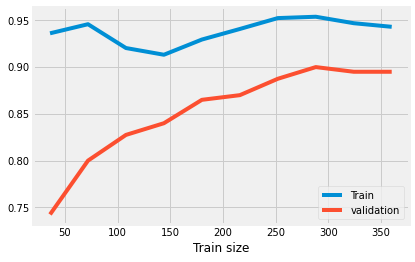

In [ ]:
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

# train sizes allows you to enter the amount of data to use for training, 
# but it's a little subtle, because we're actually going to pass percentages(%).
# Most of the time we will use the linspace function of Numpy by indicating a 
# start percentage, an end percentage, as well as a number of lots that we want to have.

print(N)

plt.plot(N, train_score.mean(axis=1), label='Train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('Train size')
plt.legend()
plt.show()

We can see that the performance no longer evolves from the moment we have more than 280-290 points in our dataset, so it shows us that the model will continue to stagnate, it is very unlikely that we will obtain better performance by having 500 or 1000 or 10000 points So this is very important information, because collecting data in the real world is expensive and you don't want to spend money on something that is not going to improve your model.